In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=(2,2), stride=(2,2))
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5), stride=(1,1), padding=(0,0))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), stride=(1,1), padding=(0,0))
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5,5), stride=(1,1), padding=(0,0))
        self.linear1 = nn.Linear(in_features=120, out_features=84)
        self.linear2 = nn.Linear(in_features=84, out_features=10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        # flatten
        x = x.reshape(x.shape[0], -1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.softmax(x)

        return x

In [3]:
x = torch.randn(64, 1, 32, 32)
model = LeNet()
print(model(x).shape)

torch.Size([64, 10])


In [10]:
# pad the input with 2 pixels on each side using transform.Pad
# and then apply transform.RandomCrop to crop the image to 32x32
my_transforms = transforms.Compose([
    transforms.Pad(2),
    transforms.ToTensor(),
])

In [11]:
batch_size = 64

train_dataset = datasets.MNIST(root = "dataset/", train = True, transform=my_transforms, download= True)
train_loader = DataLoader(dataset = train_dataset, batch_size= batch_size, shuffle= True)

test_dataset = datasets.MNIST(root = "dataset/", train = False, transform=my_transforms, download= True)
test_loader = DataLoader(dataset = test_dataset, batch_size= batch_size, shuffle= True)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train(dataloader, model, num_epochs, loss_fn, learning_rate):
    
    # optimizer
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    losses = []

    # save model
    for epoch in range(num_epochs):
        checkpoint = {"model": model.state_dict(), "optimizer": optimizer.state_dict()}

        if epoch == 2:
            torch.save(checkpoint, "checkpoint.pth")
            print(f"saved model at epoch {epoch}")
            
        for batch, (X, y )in enumerate(dataloader):
            # to cuda
            X = X.to(device = device)
            y = y.to(device = device)

            # forward
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            # set all gradients to zero on each batch
            optimizer.zero_grad()
            loss.backward()
            # gradient descent or adam step
            optimizer.step()

            losses.append(loss.item())

            if batch % 50 == 0:
                print(f"Epoch {epoch} batch {batch} loss {losses[-1]:.4f}")
            
    return losses

def test(dataloader, model, loss_fn):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:

            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [15]:
modelLeNet = LeNet()
modelLeNet.to(device)
loss_fn = nn.CrossEntropyLoss()
learning_rate = 4e-3
num_epochs = 3

losses = train(train_loader, modelLeNet, num_epochs, loss_fn, learning_rate)

Epoch 0 batch 0 loss 2.3018
Epoch 0 batch 50 loss 2.0693
Epoch 0 batch 100 loss 1.7465
Epoch 0 batch 150 loss 1.6969
Epoch 0 batch 200 loss 1.5893
Epoch 0 batch 250 loss 1.6695
Epoch 0 batch 300 loss 1.6565
Epoch 0 batch 350 loss 1.6689
Epoch 0 batch 400 loss 1.6707
Epoch 0 batch 450 loss 1.7171
Epoch 0 batch 500 loss 1.6603
Epoch 0 batch 550 loss 1.6222
Epoch 0 batch 600 loss 1.5956
Epoch 0 batch 650 loss 1.6307
Epoch 0 batch 700 loss 1.5199
Epoch 0 batch 750 loss 1.5724
Epoch 0 batch 800 loss 1.5377
Epoch 0 batch 850 loss 1.5001
Epoch 0 batch 900 loss 1.4893
Epoch 1 batch 0 loss 1.5289
Epoch 1 batch 50 loss 1.5224
Epoch 1 batch 100 loss 1.5232
Epoch 1 batch 150 loss 1.5434
Epoch 1 batch 200 loss 1.5135
Epoch 1 batch 250 loss 1.5073
Epoch 1 batch 300 loss 1.5727
Epoch 1 batch 350 loss 1.5460
Epoch 1 batch 400 loss 1.5387
Epoch 1 batch 450 loss 1.5314
Epoch 1 batch 500 loss 1.5876
Epoch 1 batch 550 loss 1.4938
Epoch 1 batch 600 loss 1.4616
Epoch 1 batch 650 loss 1.5168
Epoch 1 batch 70

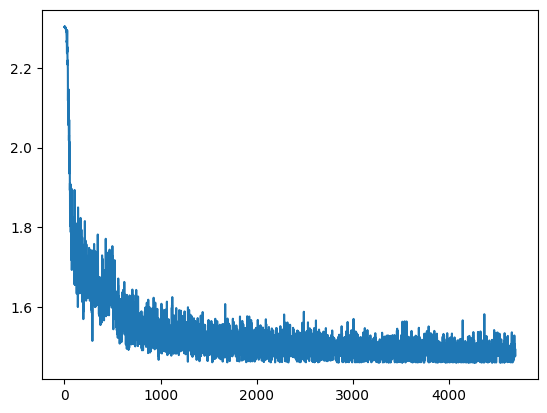

In [18]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [16]:
test(train_loader, modelLeNet, loss_fn)
test(test_loader, modelLeNet, loss_fn)

Test Error: 
 Accuracy: 97.7%, Avg loss: 1.485141 

Test Error: 
 Accuracy: 97.6%, Avg loss: 1.485563 

